<h1>Web Scraping</h1>
<p>Web scraping (or data scraping) is a technique used to collect content and data from the internet.</p>
<p>I found a tonne of tutorials on the internet to scrape movie ratings from IMDB but I haven’t found any about scraping episode ratings of all Seasons of a TV series.</p>
<p>So, I'm writing this to make your life easier.</p>
<p>In this tutorial we’ll learn to scrape multiple web pages with Python using BeautifulSoup and requests to get imdb data from all seasons of Better Call Saul. We’ll then perform some simple analysis using pandas, and matplotlib.</p>

<h2>Breaking drown Scrapping Better Call Saul IMDB ratings</h2>
<p>Get the url of that page. It should be structured like this:<br>
    https://www.imdb.com/title/tt3032476/episodes?season=1<br>
First, we will request the content of the web page by using get() method, and store the server’s response in the variable. The response is HTML code of webpage</p>

In [164]:
from requests import get
url = 'https://www.imdb.com/title/tt3032476/episodes?season=1'
response = get(url)
print(response.text[:300])


 










<!DOCTYPE html>
<html
    xmlns:og="http://ogp.me/ns#"
    xmlns:fb="http://www.facebook.com/2008/fbml">
    <head>
         

        <meta charset="utf-8">




        <script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:'java'};</script>

<script>
    if (


<h2>BeautifulSoup</h2>
<p>Beautiful Soup is a Python package for parsing HTML and XML documents. 
It creates a parse tree for parsed pages that can be used to extract data from HTML, which is useful for web scraping.</p>
<p>We’ll parse response.text by creating a BeautifulSoup object, and assign this object to html_soup. The html.parser argument indicates that we want to do the parsing using Python’s built-in HTML parser.</p>

In [165]:
from bs4 import BeautifulSoup

html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

<p>I need to parse the site to get the following data</p>
<ul>
  <li>Episode title</li>
  <li>Episode number</li>
  <li>Airdate</li>
  <li>IMDb rating</li>
  <li>Total votes</li>
  <li>Episode description</li>
</ul>  

<p>We will grab all of the instances of-  div class="info" ... from the page. There is one for each episode.</p>

In [166]:
episode_containers = html_soup.find_all('div', class_='info')
# print(episode_containers[0])

<h2>Extracting each variable that we need</h2>
<h3>Episode title</h3>
<p>To get the title we need to call title attribute from the a tag.
<p>

In [167]:
episode_containers[0].a['title']

'Uno'

<h3>Episode number</h3>
<p>Episode number in the meta tag, under the content attribute.</p>

In [168]:
episode_containers[0].meta['content']

'1'

<h3>Airdate</h3>
<p>Airdate is in the div tag with the class airdate, and we can get its contents the text attribute, afterwhich we strip() it to remove whitespace.</p>

In [169]:
episode_containers[0].find('div', class_='airdate').text.strip()

'4 Oct. 2017'

<h3>IMDb rating</h3>
<p>IMDB rating is is in the span tag with the class ipl-rating-star__rating.</p>

In [170]:
episode_containers[0].find('span', class_='ipl-rating-star__rating').text

'8.5'

<h3>Total votes</h3>

In [171]:
episode_containers[0].find('span', class_='ipl-rating-star__total-votes').text

'(18,386)'

<h3>Episode Description</h3>

In [172]:
episode_containers[0].find('div', class_='item_description').text.strip()

'Struggling public defender Jimmy McGill constructs an elaborate yet questionable plan for winning back a pair of wealthy potential clients.'

<h2>Final code– Putting it all together</h2>
<p>We can now use for loop to get data from all seasons</p>

In [173]:
# Initializing the series that the loop will populate
better_call_saul_episodes = []

# For every season in the series-- range depends on the show
for sn in range(1,7):
    # Request from the server the content of the web page by using get(), and store the server’s response in the variable response
    response = get('https://www.imdb.com/title/tt3032476/episodes?season=' + str(sn))

    # Parse the content of the request with BeautifulSoup
    page_html = BeautifulSoup(response.text, 'html.parser')

    # Select all the episode containers from the season's page
    episode_containers = page_html.find_all('div', class_ = 'info')

    # For each episode in each season
    for episodes in episode_containers:
            # Get the info of each episode on the page
            season = sn
            episode_number = episodes.meta['content']
            title = episodes.a['title']
            airdate = episodes.find('div', class_='airdate').text.strip()
            rating = episodes.find('span', class_='ipl-rating-star__rating').text
            total_votes = episodes.find('span', class_='ipl-rating-star__total-votes').text
            desc = episodes.find('div', class_='item_description').text.strip()
            # Compiling the episode info
            episode_data = [season, episode_number, title, airdate, rating, total_votes, desc]

            # Append the episode info to the complete dataset
            better_call_saul_episodes.append(episode_data)       

<h2>Making the dataframe</h2>
<p>A Pandas DataFrame is a 2 dimensional data structure, like a 2 dimensional array, or a table with rows and columns.</p>

In [174]:
import pandas as pd 
better_call_saul_episodes = pd.DataFrame(better_call_saul_episodes, columns = ['season', 'episode_number', 'title', 'airdate', 'rating', 'total_votes', 'description'])
better_call_saul_episodes.head()

,season,episode_number,title,airdate,rating,total_votes,description
0,1,1,Uno,4 Oct. 2017,8.5,"(18,386)",Struggling public defender Jimmy McGill constr...
1,1,2,Mijo,9 Feb. 2015,8.9,"(17,409)",Jimmy's latest scam has gone horribly wrong an...
2,1,3,Nacho,16 Feb. 2015,8.7,"(14,709)",Jimmy must prove that Nacho is innocent when h...
3,1,4,Hero,23 Feb. 2015,8.4,"(13,260)",Jimmy makes a bold move against Hamlin in an e...
4,1,5,Alpine Shepherd Boy,2 Mar. 2015,8.0,"(12,759)","After a strange encounter with the police, Chu..."


<h2>Data Cleaning</h2>
<p>In this step we change the data into our required format, and modify datatypes to make our lives easier further down the road.</p>

In [175]:
def remove_str(votes):
    for r in ((',',''), ('(',''),(')','')):
        votes = votes.replace(*r)
        
    return votes

In [176]:
better_call_saul_episodes['total_votes'] = better_call_saul_episodes.total_votes.apply(remove_str).astype(int)

better_call_saul_episodes.head()

,season,episode_number,title,airdate,rating,total_votes,description
0,1,1,Uno,4 Oct. 2017,8.5,18386,Struggling public defender Jimmy McGill constr...
1,1,2,Mijo,9 Feb. 2015,8.9,17409,Jimmy's latest scam has gone horribly wrong an...
2,1,3,Nacho,16 Feb. 2015,8.7,14709,Jimmy must prove that Nacho is innocent when h...
3,1,4,Hero,23 Feb. 2015,8.4,13260,Jimmy makes a bold move against Hamlin in an e...
4,1,5,Alpine Shepherd Boy,2 Mar. 2015,8.0,12759,"After a strange encounter with the police, Chu..."


In [177]:
better_call_saul_episodes['rating'] = better_call_saul_episodes.rating.astype(float)
better_call_saul_episodes['episode_number']=better_call_saul_episodes['episode_number'].apply(lambda x: '{0:0>2}'.format(x))
better_call_saul_episodes['episode'] = 'S'+better_call_saul_episodes['season'].astype(str)+', ' +'Ep'+ better_call_saul_episodes['episode_number'].astype(str)

In [178]:
better_call_saul_episodes['airdate'] = pd.to_datetime(better_call_saul_episodes.airdate)
better_call_saul_episodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   season          63 non-null     int64         
 1   episode_number  63 non-null     object        
 2   title           63 non-null     object        
 3   airdate         63 non-null     datetime64[ns]
 4   rating          63 non-null     float64       
 5   total_votes     63 non-null     int32         
 6   description     63 non-null     object        
 7   episode         63 non-null     object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 3.8+ KB


In [179]:
better_call_saul_episodes.head()


,season,episode_number,title,airdate,rating,total_votes,description,episode
0,1,01,Uno,2017-10-04,8.5,18386,Struggling public defender Jimmy McGill constr...,"S1, Ep01"
1,1,02,Mijo,2015-02-09,8.9,17409,Jimmy's latest scam has gone horribly wrong an...,"S1, Ep02"
2,1,03,Nacho,2015-02-16,8.7,14709,Jimmy must prove that Nacho is innocent when h...,"S1, Ep03"
3,1,04,Hero,2015-02-23,8.4,13260,Jimmy makes a bold move against Hamlin in an e...,"S1, Ep04"
4,1,05,Alpine Shepherd Boy,2015-03-02,8.0,12759,"After a strange encounter with the police, Chu...","S1, Ep05"


<h2>Saving the data as a CSV file</h2>


In [180]:
better_call_saul_episodes.to_csv('better_call_saul_episodes_IMDb_Ratings.csv',index=False)

<h2>Visualizing Data</h2>

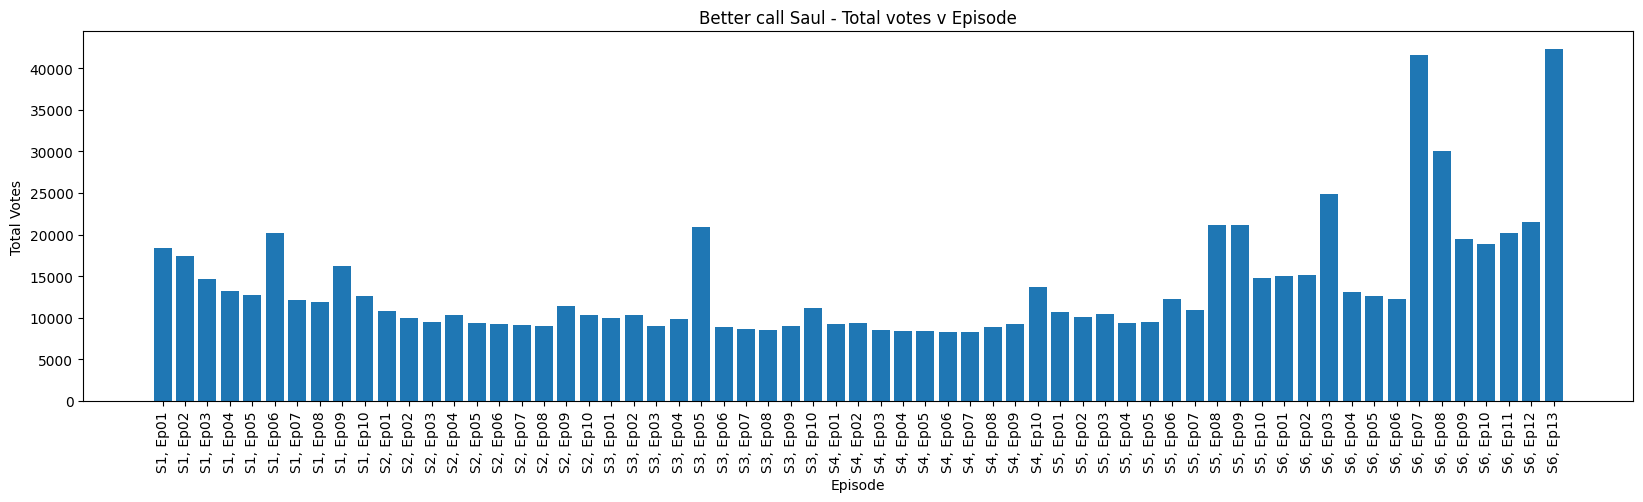

In [181]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,4.8))

x = np.array(better_call_saul_episodes['episode'])
y = np.array(better_call_saul_episodes['total_votes'])

plt.title("Better call Saul - Total votes v Episode")
plt.xlabel("Episode")
plt.ylabel("Total Votes")

plt.bar(x, y)
plt.xticks(rotation=90)


plt.show()

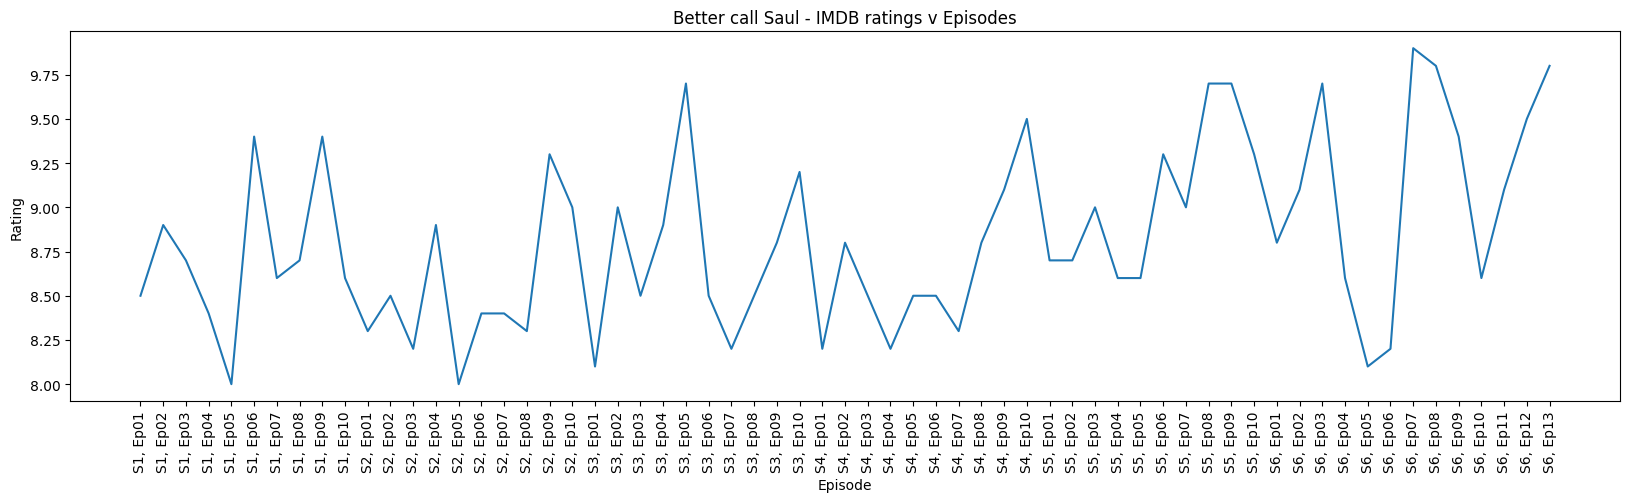

In [182]:
plt.figure(figsize=(20,4.8))

xpoints = np.array(better_call_saul_episodes['episode'])
ypoints = np.array(better_call_saul_episodes['rating'])


plt.title("Better call Saul - IMDB ratings v Episodes")
plt.xlabel("Episode")
plt.ylabel("Rating")

plt.plot(xpoints,ypoints)
plt.xticks(rotation=90)

plt.show()

<h2>Insights</h2>

In [183]:
print("\nDescriptive statistics of whole dataframe:\n")
stats = better_call_saul_episodes.describe(include = 'all')
print(stats)


Descriptive statistics of whole dataframe:

           season episode_number title              airdate     rating  \
count   63.000000             63    63                   63  63.000000   
unique        NaN             13    63                   62        NaN   
top           NaN             01   Uno  2022-04-18 00:00:00        NaN   
freq          NaN              6     1                    2        NaN   
first         NaN            NaN   NaN  2015-02-09 00:00:00        NaN   
last          NaN            NaN   NaN  2022-08-15 00:00:00        NaN   
mean     3.619048            NaN   NaN                  NaN   8.817460   
std      1.763689            NaN   NaN                  NaN   0.510389   
min      1.000000            NaN   NaN                  NaN   8.000000   
25%      2.000000            NaN   NaN                  NaN   8.500000   
50%      4.000000            NaN   NaN                  NaN   8.700000   
75%      5.000000            NaN   NaN                  NaN   9.150

C:\Users\aravi\AppData\Local\Temp\ipykernel_1948\1525126216.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  stats = better_call_saul_episodes.describe(include = 'all')


In [184]:
highest_rating = better_call_saul_episodes['rating'].idxmax()
better_call_saul_episodes.loc[highest_rating]

season                                                            6
episode_number                                                   07
title                                            Plan and Execution
airdate                                         2022-05-23 00:00:00
rating                                                          9.9
total_votes                                                   41533
description       Jimmy and Kim deal with a last-minute snag in ...
episode                                                    S6, Ep07
Name: 56, dtype: object

In [185]:
highest_views = better_call_saul_episodes['total_votes'].idxmax()
better_call_saul_episodes.loc[highest_views]

season                                                            6
episode_number                                                   13
title                                                     Saul Gone
airdate                                         2022-08-15 00:00:00
rating                                                          9.8
total_votes                                                   42317
description       Six years before he meets Walter White, small-...
episode                                                    S6, Ep13
Name: 62, dtype: object

<b>In conclusion, The average rating of this show is 8.817460. The episode with highest number of votes is Saul Gone(S6, Ep13) with nearly 43,000 votes. The highest rated episode of this series is Plan and Execution(S6, Ep07) with a rating of 9.9 .</b>